<a href="https://colab.research.google.com/github/HarrisonGrubb/DataScienceForBusinessAnalytics/blob/master/AirBnB%20Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reading in the data and installing the necessary packages

In [ ]:
!pip install shap

In [ ]:
from datetime import date
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
import numpy as np
from textblob import TextBlob
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import  DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from sklearn.feature_extraction.text import CountVectorizer
import plotly.graph_objects as go
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from google.colab import drive
from sklearn.neighbors import KNeighborsRegressor
import shap
import xgboost as xgb
from xgboost import plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from scipy.stats import uniform, truncnorm, randint
import pickle
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the data from Google Drive
df = pd.read_csv('/content/drive/My Drive/Data Science Technical Project/training_data.csv')
df_eval = pd.read_csv('/content/drive/My Drive/Data Science Technical Project/validation_data.csv')

In [ ]:
# Review the data to ensure the import worked
df.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,name_count,summary_count,space_count,description_count,neighborhood_overview_count,notes_count,transit_count,access_count,interaction_count,house_rules_count,host_about_count,empty_name,empty_summary,empty_space,empty_description,empty_neighborhood_overview,empty_notes,empty_transit,empty_access,empty_interaction,...,amens=Internet,amens=Iron,amens=Keypad,amens=Laptop friendly workspace,amens=Lock on bedroom door,amens=Lockbox,amens=Long term stays allowed,amens=Luggage dropoff allowed,amens=Microwave,amens=Other,amens=Outlet covers,amens=Oven,amens=Pack ’n Play/travel crib,amens=Paid parking off premises,amens=Paid parking on premises,amens=Patio or balcony,amens=Pets allowed,amens=Pets live on this property,amens=Pocket wifi,amens=Pool,amens=Private entrance,amens=Private living room,amens=Refrigerator,amens=Room-darkening shades,amens=Safety card,amens=Self check-in,amens=Shampoo,amens=Shower gel,amens=Single level home,amens=Smart lock,amens=Smoke detector,amens=Smoking allowed,amens=Stove,amens=Suitable for events,amens=TV,amens=Trash can,amens=Washer,amens=Wheelchair accessible,amens=Window guards,total_price
0,0.0,100.0,0,1,1,5,1.0,1.0,1.0,4,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,7,68,10,172,19,22,21,20,25,1,1,0,0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,153.333333
1,100.0,88.0,1,1,1,4,1.0,1.0,2.0,30,99.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,4,58,9,154,39,1,13,22,13,50,94,0,0,0,0,0,1,0,0,0,...,1,1,0,1,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,1,0,1,0,0,250.000000
2,0.0,0.0,0,1,1,2,1.0,1.0,1.0,15,91.0,10.0,9.0,10.0,9.0,9.0,9.0,1,0,0,8,30,36,145,14,25,12,13,15,17,1,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,47.000000
3,60.0,35.0,0,1,1,3,1.0,1.0,0.0,1,100.0,10.0,10.0,10.0,10.0,10.0,10.0,0,0,0,7,81,26,114,1,1,1,7,1,18,100,0,0,0,0,1,1,1,0,1,...,0,1,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,110.000000
4,79.0,100.0,1,1,1,2,1.0,1.0,1.0,11,93.0,10.0,9.0,10.0,10.0,9.0,8.0,1,0,0,4,6,24,133,44,6,29,1,24,5,17,0,0,0,0,0,0,0,1,0,...,0,1,0,1,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,112.333333


In [ ]:
df.describe()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_has_profile_pic,host_identity_verified,accommodates,bathrooms,bedrooms,beds,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,require_guest_profile_picture,require_guest_phone_verification,name_count,summary_count,space_count,description_count,neighborhood_overview_count,notes_count,transit_count,access_count,interaction_count,house_rules_count,host_about_count,empty_name,empty_summary,empty_space,empty_description,empty_neighborhood_overview,empty_notes,empty_transit,empty_access,empty_interaction,...,amens=Internet,amens=Iron,amens=Keypad,amens=Laptop friendly workspace,amens=Lock on bedroom door,amens=Lockbox,amens=Long term stays allowed,amens=Luggage dropoff allowed,amens=Microwave,amens=Other,amens=Outlet covers,amens=Oven,amens=Pack ’n Play/travel crib,amens=Paid parking off premises,amens=Paid parking on premises,amens=Patio or balcony,amens=Pets allowed,amens=Pets live on this property,amens=Pocket wifi,amens=Pool,amens=Private entrance,amens=Private living room,amens=Refrigerator,amens=Room-darkening shades,amens=Safety card,amens=Self check-in,amens=Shampoo,amens=Shower gel,amens=Single level home,amens=Smart lock,amens=Smoke detector,amens=Smoking allowed,amens=Stove,amens=Suitable for events,amens=TV,amens=Trash can,amens=Washer,amens=Wheelchair accessible,amens=Window guards,total_price
count,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.00000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.00000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,...,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000,45210.000000
mean,58.236651,59.675470,0.197125,0.997036,0.445432,2.833864,1.138045,1.169277,1.519089,25.352223,73.113891,9.615440,9.286069,9.736016,9.742412,7.462376,9.389999,0.374607,0.01962,0.021566,6.189184,54.531431,55.558261,132.936762,37.848861,19.601526,28.297633,14.988144,17.156426,33.953351,32.147799,0.000310,0.048529,0.28038,0.024242,0.342579,0.593453,0.340987,0.470427,0.399823,...,0.269409,0.634771,0.048352,0.636253,0.375780,0.124641,0.205928,0.165074,0.387923,0.062906,0.010484,0.371312,0.031829,0.094205,0.027936,0.081088,0.133466,0.054523,0.012519,0.016434,0.216081,0.144393,0.457487,0.042070,0.075735,0.219531,0.674939,0.047755,0.040655,0.016302,0.875691,0.048087,0.380203,0.027715,0.685733,0.064411,0.405839,0.031586,0.027715,157.977010
std,47.160202,42.640045,0.397832,0.054362,0.497019,1.818169,0.401160,0.726289,1.097777,49.202894,39.776112,0.750948,0.953231,0.660682,0.672319,4.047049,0.820420,0.484027,0.13869,0.145263,2.065319,26.914045,58.605062,55.101033,44.124726,36.496390,35.183160,24.986074,22.854770,51.739515,61.499572,0.017595,0.214884,0.44919,0.153803,0.474577,0.491194,0.474046,0.499130,0.489867,...,0.443658,0.481500,0.214512,0.481082,0.484329,0.330315,0.404383,0.371252,0.487282,0.242797,0.101856,0.483161,0.175547,0.292117,0.164792,0.272974,0.340081,0.227050,0.111189,0.127140,0.411574,0.351492,0.498195,0.200752,0.264577,0.413934,0.468403,0.213250,0.197491,0.126635,0.329937,0.213952,0.4854

In [ ]:
# Identifying the fields by type
columns_bin = []
columns_cont = []
columns_target = ['total_price']

# Any column with two or fewer unique values can be assumed to be binary
for col in df:
  if len(df[col].unique()) <= 2:
    columns_bin.append(col)
  else:
    columns_cont.append(col)
# Although total_price is continuous, we do not want to include with attributes
columns_cont.remove('total_price')

# Modeling Section


In [ ]:
# Convert price to log of price
df['log_price'] = np.log(df['total_price'])

In [ ]:
# Creating X and Y variables
X = df
Y = df['log_price']
X = X.drop(['log_price', 'total_price'], axis=1)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 42)

# Featuring Selection

Iterating over various thresholds to return best number of features to use.

In [ ]:
# DR:How many features to actually select. Then look at the scatter plot and select the number of features to load

scores = []
cut_off = []
for number in range(0, 500, 10):
  number = number/100
  select_features_uni = SelectKBest(score_func=f_regression).fit(X_train, Y_train)
  uni_df= pd.DataFrame({'feature':list(X_train.columns), 'score':select_features_uni.scores_})
  uni_df =  uni_df.sort_values(by='score', ascending=False)
  uni_df = uni_df[uni_df['score'] >= number]
  use = uni_df['feature'].tolist()
  Y = df['log_price']
  X = df[use]
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2)
  tree_model = DecisionTreeRegressor(min_samples_split= 70,min_samples_leaf=40, max_depth= 40, max_leaf_nodes= 150)
  tree_score = np.mean(cross_val_score(tree_model, X_train, Y_train, scoring='neg_mean_absolute_error', cv=5))
  scores.append(tree_score)
  cut_off.append(number)
  # print(number, len(use))


invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal
invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal
invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal
invalid value encountered in true_divide
invalid value encountered in greater
invalid value encountered in less
invalid value encountered in less_equal


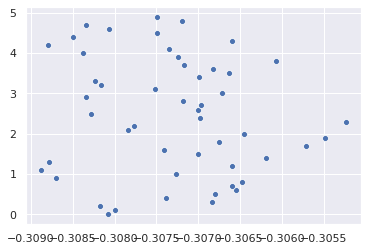

In [ ]:
sns.scatterplot(x=scores, y=cut_off)

## Creating Dataset based on the best criteria from above.  Also writing it to files to avoid having to retrain models.

#Feature Selection

Feature Engineering: SKLearn allows few methods to select features in a systematic way. They are explained below

1. Univariate Methods: Identifies correlation between each feature and label. We would know how much influence each feature has on the label. For this project, we have selected SelectKBest method
2. Wrapper Methods: Recursively cuts down features to identify the best mix. This will take care of covariance between features to a degree.
3. Embedded Methods: Parameters embedded while invoking the models.

For the project we have systematically implemented all three forms of feature selections methods to improve models accuracy and reduce training time.

Below, we are running SelectKBest on the selected feature list from above steps and trim the feature list further. The goal is include features that score above 2.2.

ALso splitting the data and writing it to files to avoid having to retrain models

* Dheeraj will polish the text here

In [ ]:
Y = df['log_price']
X = df

select_features_uni = SelectKBest(score_func=f_regression).fit(X_train, Y_train)
uni_df= pd.DataFrame({'feature':list(X_train.columns), 'score':select_features_uni.scores_})
uni_df =  uni_df.sort_values(by='score', ascending=False)
uni_df = uni_df[uni_df['score'] >= 2.2]
use = uni_df['feature'].tolist()
Y = df['log_price']
X = df[use]
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, shuffle= True)

print(X.head())
X.shape
##### Only run the commands below if you want to retrain any of the following models
X_test.to_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/X_test.csv')
X_train.to_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/X_train.csv')
Y_test.to_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/Y_test.csv')
Y_train.to_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/Y_train.csv')

   room_type=entire_home/apt  ...  nghbrhd=mount_hope
0                          1  ...                   0
1                          1  ...                   0
2                          0  ...                   0
3                          1  ...                   0
4                          0  ...                   0

[5 rows x 245 columns]


## Reading in the data from previous versions of the above step

In [ ]:
X_test = pd.read_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/X_test.csv')
X_train = pd.read_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/X_train.csv') 
Y_test = pd.read_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/Y_test.csv')
Y_train = pd.read_csv('/content/drive/My Drive/Data Science Technical Project/NYC March 2020 Airbnb Data/NYC 3.2020 Detailed listings/Y_train.csv')

# For some reason when it re-reads in it adds a column so we're dropping it
Y_train = Y_train.drop(['Unnamed: 0'], axis=1)
Y_test = Y_test.drop(['Unnamed: 0'], axis=1)
# Check to make sure there are only 1 columns
print(Y_train.head())
print(Y_test.head())

   log_price
0   4.854631
1   5.634790
2   5.105945
3   4.941642
4   4.442651
   log_price
0   4.795791
1   5.298317
2   4.110874
3   4.499810
4   5.157617


# Tuning Linear Regression Model

**Write up** : Let's attempt a basic linear regression model to get the baseline. We have seleected to run elastic net, because it allows us to control both L1 and L2 complexity. The Evaluation metric is Mean Absoute Error

***Parameters Used for this model***

*Fit Intercept:* Set it to True. Having it false will force the regression line to start from origin. This would be an edge case situation because we do not have a listing with price equal to zero. Moreover, forcing the mdoel to start from zero is not a natural fit

*L1 Ratio:* Allows us to fine tune the extent of L1 and L2 complexity control. This is an embedded feature selection parameter. In our code, loop through different values to identify the best for this model.
1.   L1 Regularization: Forces a few weight coefficients to zero to allow other regressors to take higher weight. Controls model complexity by reducing features.
2.   L2 Regulariztion: Penalizes higher weights, to prevent the model to be influenced by higher scales

*Normalization:* Set to True. This normalize values to that they are brought to a uniform scale

*Alpha:* Used for calculating LOSS value, which is used for tuning coefficients. A low value will lead to overfitting and a high value will lead to underfitting. In the project we loop through different values to identify the best

We are apply a function called RFE to recursively eliminate features with less impact. This is a wrapper selection method, as explained above. In this function, we set the number of features to select to 200. We thought this number would provide good feature sets that allow the model to generalize. The number has been identified after going through a few iterations

In [ ]:
from sklearn.model_selection import KFold
from sklearn.feature_selection import RFE
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

# create a dataframe to save model peformance. It can later be used for model evaluation
fitting_df= pd.DataFrame(columns=['model', 'complex_param', 'mae'])
# testing different values for l1_ratio. this is for controlling complexity
l1_ratio = [0.2, 0.4, 0.6, 0.8, 1]
# testing different values of alpha to be used for deriving loss values. Helps in finetuning the model coefficients
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

for i in l1_ratio:
  mae_list = []
  for j in alpha:
    model = ElasticNet(alpha=j, l1_ratio=i, fit_intercept = True, normalize = True )
    rfe = RFE(model, n_features_to_select = 200, step = 1)
    rfe = rfe.fit(X_train, np.ravel(Y_train))    
    rfe_es_df = pd.DataFrame({'feature':list(X_train.columns), 'ranking':rfe.ranking_})
    rfe_es_df= rfe_es_df[rfe_es_df['ranking'] < 50]
    x_es_train = X_train[rfe_es_df['feature']]
    x_es_test =  X_test[rfe_es_df['feature']]
    model.fit(x_es_train, np.ravel(Y_train))
    y_prediction = model.predict(x_es_test)
    mae = mean_absolute_error(Y_test, y_prediction)
    mae_list.append(mae)
  mae_min = min(mae_list)
  fitting_df = fitting_df.append({'model':'linear_model', 'complex_param':i, 'mae':mae_min}, ignore_index=True)

In [ ]:
fitting_df

,model,complex_param,mae
0,linear_model,0.2,0.535029
1,linear_model,0.4,0.535029
2,linear_model,0.6,0.535029
3,linear_model,0.8,0.535029
4,linear_model,1.0,0.535029


# Tuning Decision Tree Regressor
Another model we tried is the Decision Tree Regressor. This model performas tree classification to regression problems. 

The more deeper it is, the better it fits the training data. However, trees that are very deep will overfit and predict test data poorly. In the code we are trying a few depths for our model. The best MAE will be the ideal tree depth. Also, the criterion is set to MAE. This ensures that each split ensures lowest MAE. Together, they serve as embedded feature selection process.

We do not need a wrapper feature selection process because each split in the decision tree is made to ensure the MAE is lower. The features are selected accordinly. Applying RFE function will not give us added benefit

In [ ]:
from sklearn.tree import DecisionTreeRegressor
depth = 5
for i in range(1,20, 2):
  model = DecisionTreeRegressor(max_depth= i*depth, criterion="mae", splitter='best')
  model.fit(X_train, Y_train)
  y_prediction = model.predict(X_test)
  mae = mean_absolute_error(Y_test,y_prediction)
  fitting_df = fitting_df.append({'model':'decision_regressor', 'complex_param':i*depth, 'mae':mae}, ignore_index=True)

# not applying RFE because decision trees are split recursively based on best features
# the best split is when max dept = 10. so i will try lower depths next time. do not change the code

In [ ]:
fitting_df

,model,complex_param,mae
0,linear_model,0.2,0.535029
1,linear_model,0.4,0.535029
2,linear_model,0.6,0.535029
3,linear_model,0.8,0.535029
4,linear_model,1.0,0.535029
5,decision_regressor,5.0,0.327232
6,decision_regressor,15.0,0.328138
7,decision_regressor,25.0,0.370515
8,decision_regressor,35.0,0.387819
9,decision_regressor,45.0,0.387723



# Tuning Gradient Boost Model


In [ ]:
param_grid = {'min_samples_leaf': [10, 5],
              'max_features': [150, 225]}

param_range = {'n_estimators': randint(1600, 2400),
               'learning_rate': truncnorm(a=0, b=1, loc=0.1, scale=0.1),
               'min_samples_split': randint(100, 400)}
n_jobs = 60

gb_mid = GradientBoostingRegressor(loss='ls', random_state=42, n_estimators=1600, min_samples_split=200)

regressor = GridSearchCV(estimator=gb_mid, param_grid=param_grid, n_jobs=n_jobs, scoring='neg_mean_absolute_error',cv=3)

# regressor = RandomizedSearchCV(gb_mid,param_distributions=param_range, n_iter=100, n_jobs= n_jobs, cv=4)


In [ ]:
regressor.fit(X_train, Y_train)
print(regressor.best_estimator_)
print(regressor.score(X_train, Y_train))


A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=150, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=200,
                          min_weight_fraction_leaf=0.0, n_estimators=1600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
-0.24689269118095325


In [ ]:
preds = regressor.predict(X_test)

print(regressor.score(X_test,Y_test))

pred_score = mean_absolute_error(Y_test, preds)
print(pred_score)

dollar_actuals = np.exp(Y_test)
gb_dollar_predict = np.exp(preds)
print('$ Dollars off', mean_absolute_error(dollar_actuals, gb_dollar_predict))
print('$ Avg. Rent', np.mean(dollar_actuals))


#### Only run this code if you want overwrite the existing model
file_name = '/content/drive/My Drive/Data Science Technical Project/gradientboost_random_search.sav'
pickle.dump(regressor,open(file_name, 'wb'))

-0.27022608090754013
0.27022608090754013
$ Dollars off 42.01189087365483
$ Avg. Rent log_price    156.770299
dtype: float64


### Read in a Previously Trained Model

Instead of sitting through a ~40 minute training period you can unpickle and use the last saved model.

Please review the MAE below to decide if you want to retrain.

You should retrain if you changed the data.

In [ ]:
regressor = pickle.load(open('/content/drive/My Drive/Data Science Technical Project/gradientboost_random_search.sav', 'rb'))
result = regressor.score(X_test, Y_test)

preds = regressor.predict(X_test)
# print(regressor.score(X_test,Y_test))

actuals = Y_test
pred_score = mean_absolute_error(Y_test, preds)
# print(pred_score)
print('$ Log Dollars off',mean_absolute_error(actuals, preds))


dollar_actuals = np.exp(Y_test)
gb_dollar_predict = np.exp(preds)
print('$Pred Dollars off', mean_absolute_error(dollar_actuals, gb_dollar_predict))

mean_train = np.mean(np.exp(Y_train))
baseline_predicts = pd.Series(data= np.ones(len(Y_test)-1))
baseline_predicts = baseline_predicts.multiply(mean_train,fill_value=mean_train)
dollar_mae_base = mean_absolute_error(dollar_actuals, baseline_predicts)
print('$Base Dollar off',dollar_mae_base)
print('$ Avg. Rent', np.mean(dollar_actuals))




# print('$ Dollars off', mean_absolute_error(dollar_actuals, dollar_predict))
# print('$ Avg. Rent', np.mean(dollar_actuals))

$ Log Dollars off 0.27022608090754013
$Pred Dollars off 42.01189087365483
$Base Dollar off 86.13091174582763
$ Avg. Rent log_price    156.770299
dtype: float64


### Generating Prediction Intervals

You can modify the alpha ranges to widen/narrow the bands

If you retrain the above model and want to use it's parameter settings you'll need to copy the best predictor to the scenarios below.

In [ ]:
# https://towardsdatascience.com/how-to-generate-prediction-intervals-with-scikit-learn-and-python-ab3899f992ed

#using gradient boost regression to predict interval
#setting upper and lower bounds
lower_alpha = 0.05
upper_alpha = 0.95


#creating models for each range
gb_lower = GradientBoostingRegressor(alpha=lower_alpha, ccp_alpha=0.0, 
                          init=None, learning_rate=0.1, loss='quantile', max_depth=3,
                          max_features=150, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=200,
                          min_weight_fraction_leaf=0.0, n_estimators=1600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

gb_mid = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=150, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=200,
                          min_weight_fraction_leaf=0.0, n_estimators=1600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

gb_upper = GradientBoostingRegressor(alpha=upper_alpha, ccp_alpha=0.0, 
                          init=None, learning_rate=0.1, loss='quantile', max_depth=3,
                          max_features=150, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=200,
                          min_weight_fraction_leaf=0.0, n_estimators=1600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
## Create dataframe to review interval predictions
gb_predictions = pd.DataFrame(Y_test)
gb_predictions['price'] = np.exp(gb_predictions.log_price)

## Point Estimate
gb_mid.fit(X_train, Y_train)
gb_predictions['mid'] = gb_mid.predict(X_test)
gb_predictions['mid'] = np.exp(gb_predictions.mid)

## Lower Bound
gb_lower.fit(X_train, Y_train)
gb_predictions['lower'] = gb_lower.predict(X_test)
gb_predictions['lower'] = np.exp(gb_predictions.lower)

## Upper Bound
gb_upper.fit(X_train, Y_train)
gb_predictions['upper'] =gb_upper.predict(X_test)
gb_predictions['upper'] = np.exp(gb_predictions.upper)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


    log_price       price         mid       lower       upper
0    4.795791  121.000000  197.837855  101.889694  326.025300
1    5.298317  200.000000  201.306168  128.044967  292.371870
2    4.110874   61.000000   72.427560   46.130900  108.553821
3    4.499810   90.000000  100.403607   41.295779  141.976986
4    5.157617  173.750000  205.426592  121.349190  352.447728
5    5.281510  196.666667  135.451478   85.359893  187.246118
6    4.777020  118.750000  115.770082   80.727984  164.653311
7    4.406719   82.000000   55.192809   37.051668   96.146870
8    4.682131  108.000000  101.160892   70.093827  151.498001
9    5.135798  170.000000  181.477283  108.822002  369.113666
10   3.976562   53.333333   56.460176   41.709463  105.008537
11   6.054439  426.000000  404.006322  261.706550  740.314087
12   5.970411  391.666667  370.181792  165.095164  501.078520
13   5.339139  208.333333  169.881536   97.089967  345.684355
14   5.857933  350.000000  319.048440  136.775524  626.062368
15   4.8

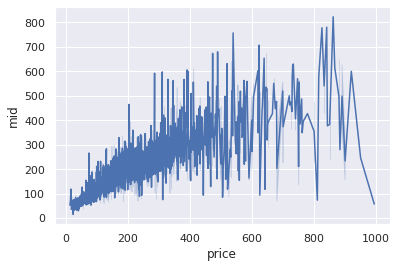

In [ ]:
# Optional plot graph to compare predictions to actuals
# Optional write file to examine prediction intervals
print(gb_predictions.head(20))
sns.lineplot(x=gb_predictions['price'], y=gb_predictions['mid'], )
gb_predictions.to_csv('intervals.csv')

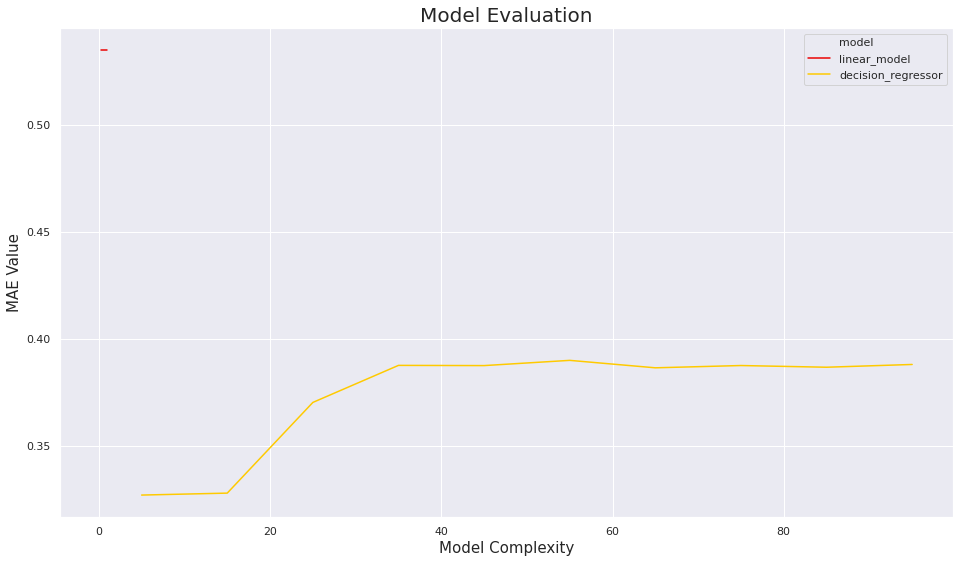

In [ ]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize = (16,9))
sns.set(style='darkgrid',)
sns.lineplot(x = "complex_param", y = "mae", data = fitting_df, hue = "model", palette = "hot", dashes = False, legend="brief")
plt.title("Model Evaluation", fontsize = 20)
plt.xlabel("Model Complexity", fontsize = 15)
plt.ylabel("MAE Value", fontsize = 15)
plt.show()

# Model Evaluation

So far we have implemented a few models. Now let's evaluate their peformance on a Fitting Curve. It allows us to quickly identy the best model and its respective complexity level quickly

We are using the dataframe fitting_df for this.

# Response Curve

Based on the fitting curve, we have identify that Decision Tree Regressor gives us the best performance at depth 10. So our prediction model should be based on it. 

To tune the model further, let's see how much of training is needed for our model to be able to predict well. This helps in generalizing our model even more, as it prevents overfitting to a degree.

In the below code, I am trying different splits of train and test data

In [ ]:
# The above write up will change if Harrison's models beat DecisionTree Regressor.

response_df= pd.DataFrame(columns=['train_size', 'mae'])
size = [0.5,0.6,0.7,0.8,0.9]

# Extract the complexity level associated with lowest MAE
param = list(fitting_df[fitting_df['mae']== min(fitting_df['mae'])]['complex_param'])

# Loop thorugh different combinations of train/test plits
for s in size:
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=s, shuffle=True)
  model = DecisionTreeRegressor(max_depth= 15, criterion="mae", splitter='best')
  model.fit(x_train, y_train)
  y_prediction = model.predict(x_test)
  mae = mean_absolute_error(y_test,y_prediction)
  response_df = response_df.append({'train_size':s, 'mae':mae}, ignore_index=True)

# Note: The max_depth value should be equal to param

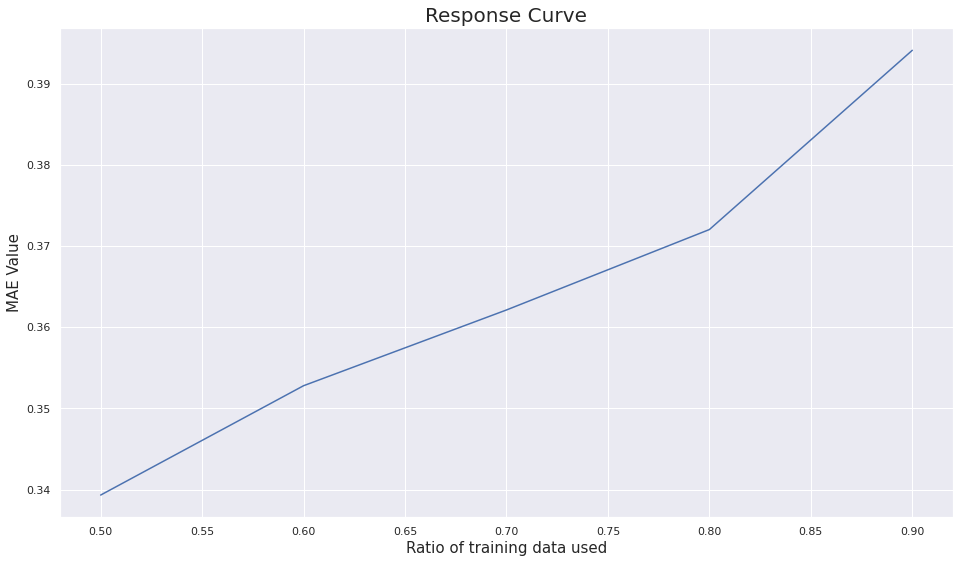

In [ ]:
# Generate response curve
plt.figure(figsize = (16,9))
sns.set(style='darkgrid',)
sns.lineplot(x = "train_size", y = "mae", data = response_df, palette = "hot", dashes = False, legend="brief",)
plt.title("Response Curve", fontsize = 20)
plt.xlabel("Ratio of training data used", fontsize = 15)
plt.ylabel("MAE Value", fontsize = 15)
plt.show()

# SHAP Visuals

In [ ]:
# Adjust the model in TreeExplainer
explainer = shap.TreeExplainer(gb_mid)
shap_values = explainer.shap_values(X_test)
expected_value = explainer.expected_value


Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [ ]:
# Force Plot
shap.initjs()
shap.force_plot(explainer.expected_value,shap_values[0,:], X_test.iloc[2010,:])

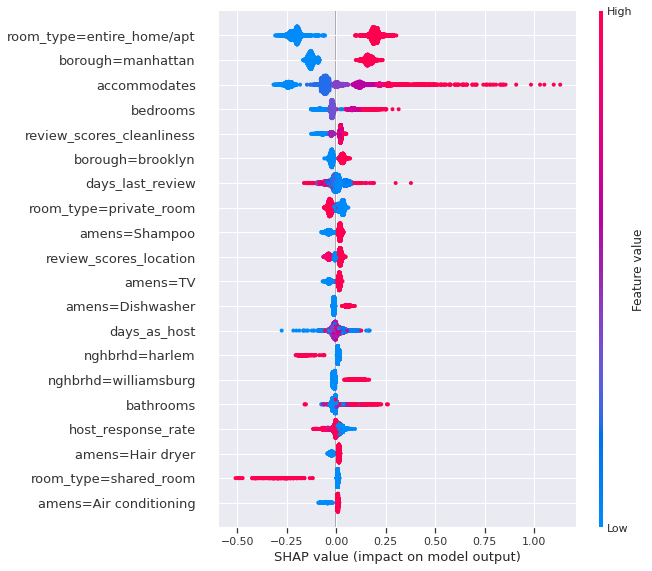

In [ ]:
# Summary Plot
shap.summary_plot(shap_values, X_test)

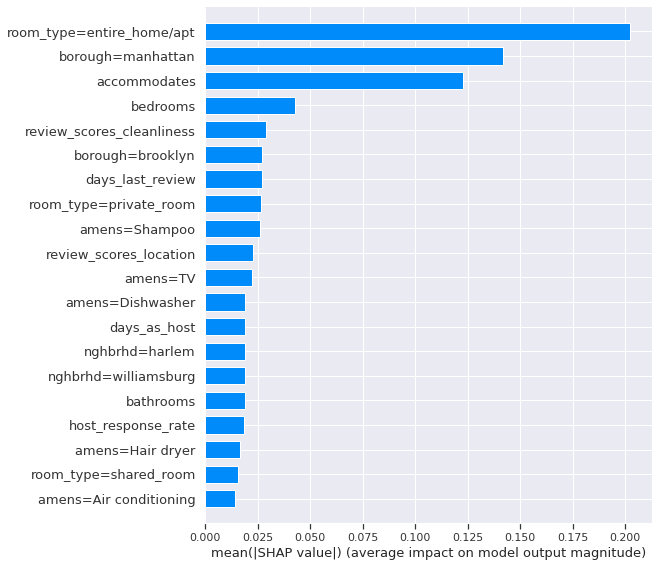

In [ ]:
shap.summary_plot(shap_values, X_test, plot_type='bar')

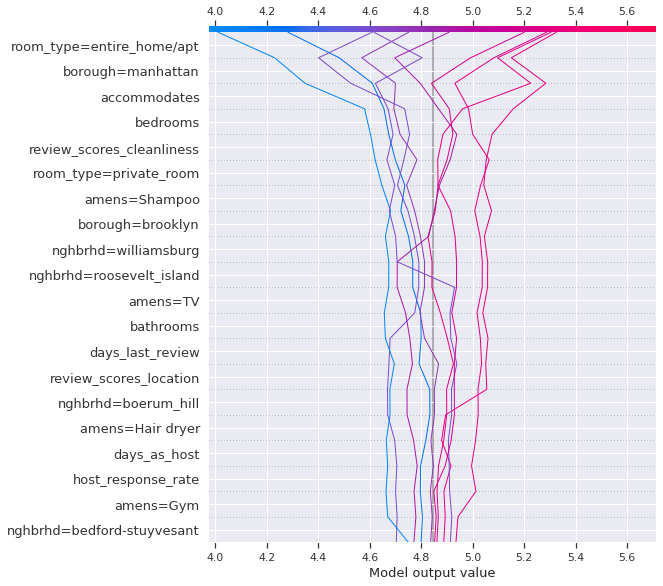

In [ ]:
## Decision Plot
select = range(50)
features = X_test.iloc[select]
features_display = X_test.loc[features.index]

shap.decision_plot(expected_value[0:10],shap_values[0:10],features_display, ignore_warnings=True)
# https://slundberg.github.io/shap/notebooks/plots/decision_plot.html#Compare-and-contrast-predictions-for-several-models
# https://towardsdatascience.com/introducing-shap-decision-plots-52ed3b4a1cba

# Validation

Finally we test the model against our holdout data and compare it to a simple benchmark (straight-line prediction based on the "accommodates", "bedrooms", and "bathrooms" fields, which were some of the top-scoring continuous variables that would pass domain knowledge validation).

In [ ]:
# Load holdout data
X_eval_train = df
X_eval_train = X_eval_train.drop(['total_price'], axis=1)
Y_eval_train = df['total_price']

X_eval_test = df_eval
X_eval_test = X_eval_test.drop(['total_price'], axis=1)
Y_eval_test = df_eval['total_price']

X_alt_train = df[['accommodates','bedrooms','bathrooms']]
Y_alt_train = df['total_price']

X_alt_eval = df_eval[['accommodates','bedrooms','bathrooms']]
Y_alt_eval = df_eval['total_price']

In [ ]:
# Filter out unused features from holdout set
for col in X_eval_train:
  if col not in X_test:
    X_eval_train = X_eval_train.drop(col, axis = 1)

for col in X_eval_test:
  if col not in X_test:
    X_eval_test = X_eval_test.drop(col, axis = 1)

In [ ]:
# Find mean absolute error of our model, trained on entire training set
model_test = pickle.load(open('/content/drive/My Drive/Data Science Technical Project/gradientboost_random_search.sav', 'rb'))
model_test.fit(X_eval_train, Y_eval_train)
Y_eval_pred = model_test.predict(X_eval_test)
mae_model = mean_absolute_error(Y_eval_test,Y_eval_pred)
print("Our model's mean absolute error:",mae_model)

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.


Our model's mean absolute error: 43.23977610940061


In [ ]:
# Find mean absolute error of simple model
model_alt = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=3, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=200,
                          min_weight_fraction_leaf=0.0, n_estimators=1600,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

model_alt.fit(X_alt_train, Y_alt_train)
Y_alt_pred = model_alt.predict(X_alt_eval)
mae_alt = mean_absolute_error(Y_alt_eval,Y_alt_pred)
print("Basic model's mean absolute error:",mae_alt)




Basic model's mean absolute error: 62.808745672068625


In [ ]:
# Find improvement above basic model
print("Our model contains %0.2f%% of the mean absolute error of the basic model." % (mae_model * 100/mae_alt))

Our model contains 68.84% of the mean absolute error of the basic model.
